Install necessary libraries

In [ ]:
!pip install torch numpy pandas scikit-learn matplotlib

Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt


Load and preprocess data, returning input sequences, targets and scaler for inverse transformation.

In [ ]:
def preprocess_data(filename, seq_len):
    # Load the data
    df = pd.read_csv(filename)
    closed_prices = df["Price"]

    # Scale the data
    scaler = MinMaxScaler()
    scaled_price = scaler.fit_transform(np.array(closed_prices)[..., None]).squeeze()

    # Create sequences
    X, y = [], []
    for i in range(len(scaled_price) - seq_len):
        X.append(scaled_price[i:i + seq_len])
        y.append(scaled_price[i + seq_len])

    X = np.array(X)[..., None]
    y = np.array(y)[..., None]
    return X, y, scaler

# Define sequence length
seq_len = 15

# Load and preprocess data
X, y, scaler = preprocess_data("XRP hday.csv", seq_len)

# Split into training and testing sets
train_size = int(0.8 * X.shape[0])
train_x, train_y = X[:train_size], y[:train_size]
test_x, test_y = X[train_size:], y[train_size:]

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)


Define the Model BiLSTM

In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size_lstm):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size_lstm, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size_lstm * 2, 1)

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        return self.fc(lstm_output[:, -1, :])
model = BiLSTMModel(input_size=1, hidden_size_lstm=64)

Train the Model

In [ ]:
def train_model(model, train_x, train_y, num_epochs=100, learning_rate=0.001, batch_size=32):
    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Create DataLoader for batch processing
    train_dataset = TensorDataset(train_x, train_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

train_model(model, train_x, train_y, num_epochs=100, learning_rate=0.001, batch_size=32)

Epoch 0/100, Loss: 0.028842201468367606
Epoch 10/100, Loss: 0.0010752185424700235
Epoch 20/100, Loss: 0.000783084376449458
Epoch 30/100, Loss: 0.0007530086961476348
Epoch 40/100, Loss: 0.0007536549786052022
Epoch 50/100, Loss: 0.0007490303162343573
Epoch 60/100, Loss: 0.0007618835508578625
Epoch 70/100, Loss: 0.0007309181713096153
Epoch 80/100, Loss: 0.0007375726759514342
Epoch 90/100, Loss: 0.0007855496276020765


Evaluate the Model

In [ ]:
def evaluate_model(model, X, y, scaler):
    model.eval()
    with torch.no_grad():
        output = model(X)
    pred = scaler.inverse_transform(output.numpy())
    real = scaler.inverse_transform(y)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(real, pred))
    mae = mean_absolute_error(real, pred)
    mape = mean_absolute_percentage_error(real, pred)

    metrics = {"RMSE": rmse, "MAE": mae, "MAPE": mape}
    return pred, real, metrics

# Evaluate on test data
pred, real, metrics = evaluate_model(model, test_x, test_y.numpy(), scaler)
print("Evaluation Metrics:", metrics)


Evaluation Metrics: {'RMSE': 0.018605977, 'MAE': 0.016958822, 'MAPE': 0.078500435}


 Visualize Predictions

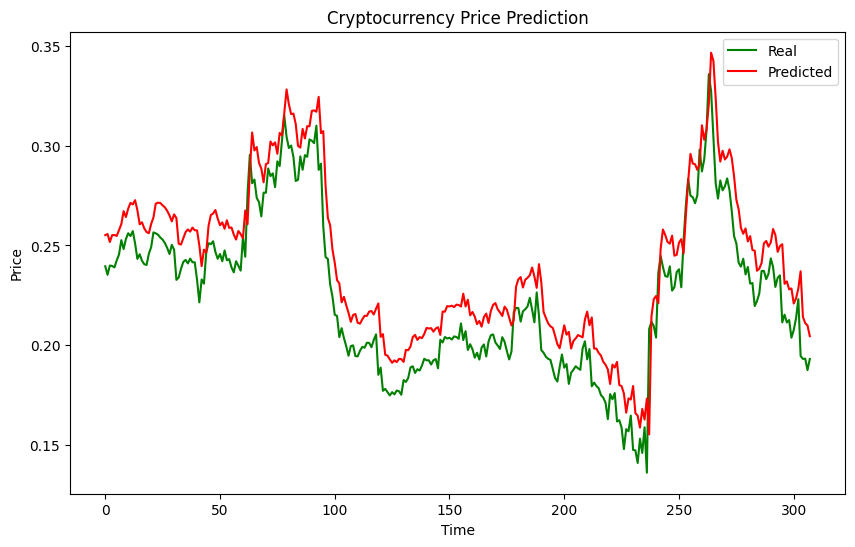

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(real, label="Real", color="green")
plt.plot(pred, label="Predicted", color="red")
plt.title("Cryptocurrency Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
